# Absolute player positions dataframe in a match

A preprocessing step to extract the player positions and create orderly dataframes.

In [4]:
import pymongo

import utils
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# specific utils

def savepickle(model,path):
    """save model to file"""
    fileout = open(path + '.pkl', 'wb')
    pickle.dump(model,fileout)
    fileout.close()
    
    
def loadpickle(path):
    """load model from file"""
    filein = open(path + '.pkl', 'rb')
    model = pickle.load(filein)
    filein.close()    
    return model

In [3]:
dbname = 'lol2'
user = 'lol2i'
passw = 'GoogleTest19'
ip = "5.196.92.209"
port = 35420

client = pymongo.MongoClient(ip,port,username=user,password=passw,authSource=dbname)

db = client[dbname]

game = db.timelines.find({'gameId': 4060650926})[0]

In [4]:
game.keys()

dict_keys(['_id', 'userName', 'gameId', 'timeline'])

In [5]:
playerids = utils.getPlayerIds(game['timeline']['frames'])
playerids

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

In [6]:
# extract the positions for each player from the timeline collection
positions = utils.getAllPlayersPositions(game, playerids)

In [7]:
# load them into a dataframe
df = utils.dataFramefromAllPositions(positions,playerids)

In [8]:
# create a column to encode each player's team
df['team'] = df.playerid.apply(lambda x: 'blue' if int(x)<6 else 'red')

In [9]:
# how does the dataframe looks?
df.head()

,playerid,x,y,timestamp,team
0,1,560,581,0,blue
1,1,6577,6644,60026,blue
2,1,7320,7077,120041,blue
3,1,7347,7600,180055,blue
4,1,6876,7198,240065,blue


#### Now let's look at the games collection to extract the players' global statistics

In [10]:
# what data can we collect?
game.keys()

dict_keys(['_id', 'userName', 'gameId', 'timeline'])

In [11]:
gameid = db.games.find({'gameId': 4060650926})[0]

In [12]:
gameid.keys()

dict_keys(['_id', 'gameId', 'platformId', 'gameCreation', 'gameDuration', 'queueId', 'mapId', 'seasonId', 'gameVersion', 'gameMode', 'gameType', 'teams', 'participants', 'participantIdentities'])

In [13]:
# add a column to store the game result by team
df['win'] = df.playerid.apply(lambda x: gameid['teams'][0]['win'] if int(x)<6 else gameid['teams'][1]['win'])

In [14]:
# could be useful to have the playerid as a numeric type
df['intplayer'] = df.playerid.astype(int)

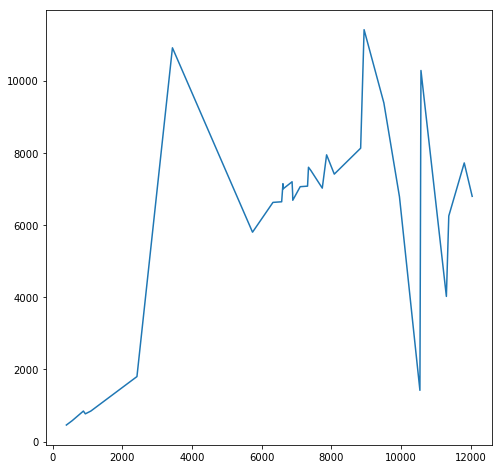

In [15]:
plt.figure(figsize=(8,8))
pid = '1'
orderedpos = sorted(list(zip(df[df.playerid==pid].x,df[df.playerid==pid].y)),key=lambda x:x[0])
ax = sns.lineplot(x=[op[0] for op in orderedpos], y=[op[1] for op in orderedpos])

In [16]:
# the dataframe has been stacked so we need to reset the index
df.reset_index(drop=True, inplace=True)
df.head()

,playerid,x,y,timestamp,team,win,intplayer
0,1,560,581,0,blue,Win,1
1,1,6577,6644,60026,blue,Win,1
2,1,7320,7077,120041,blue,Win,1
3,1,7347,7600,180055,blue,Win,1
4,1,6876,7198,240065,blue,Win,1


In [18]:
# positions at early stage
df[df.timestamp//60000 +1 == 10]

,playerid,x,y,timestamp,team,win,intplayer
9,1,1098,849,540142,blue,Win,1
41,2,11874,2071,540142,blue,Win,2
73,3,7757,6780,540142,blue,Win,3
105,4,3366,13224,540142,blue,Win,4
137,5,12269,2526,540142,blue,Win,5
169,6,9207,9042,540142,red,Fail,6
201,7,4266,13645,540142,red,Fail,7
233,8,8230,8332,540142,red,Fail,8
265,9,13417,2490,540142,red,Fail,9
297,10,13248,2653,540142,red,Fail,10


In [19]:
# positions at middle stage
df[df.timestamp//60000 +1 == 20]

,playerid,x,y,timestamp,team,win,intplayer
19,1,883,848,1140349,blue,Win,1
51,2,9496,10129,1140349,blue,Win,2
83,3,8106,9984,1140349,blue,Win,3
115,4,10027,9891,1140349,blue,Win,4
147,5,9004,9969,1140349,blue,Win,5
179,6,13934,14010,1140349,red,Fail,6
211,7,10843,10580,1140349,red,Fail,7
243,8,9534,9274,1140349,red,Fail,8
275,9,10994,11128,1140349,red,Fail,9
307,10,8273,10319,1140349,red,Fail,10


In [20]:
# positions at late stage
df[df.timestamp//60000 +1 == 30]

,playerid,x,y,timestamp,team,win,intplayer
29,1,11820,7720,1740537,blue,Win,1
61,2,11568,7685,1740537,blue,Win,2
93,3,7721,10298,1740537,blue,Win,3
125,4,6999,12492,1740537,blue,Win,4
157,5,7474,6779,1740537,blue,Win,5
189,6,10871,7617,1740537,red,Fail,6
221,7,11415,8124,1740537,red,Fail,7
253,8,12197,8680,1740537,red,Fail,8
285,9,11583,7714,1740537,red,Fail,9
317,10,11483,8703,1740537,red,Fail,10


In [21]:
# get the contextual info about the players
allcontextslist = utils.getPlayersGlobalStats(game,playerids)

In [26]:
df_context = pd.DataFrame(allcontextslist)
df_context.head()

,currentGold,dominionScore,jungleMinionsKilled,level,minionsKilled,p,timestamp,totalGold,xp
0,500,0,0,1,0,1,0,500,0
1,500,0,0,1,0,2,0,500,0
2,500,0,0,1,0,3,0,500,0
3,500,0,0,1,0,4,0,500,0
4,500,0,0,1,0,5,0,500,0


In [27]:
allevents = utils.getGameEventsSequences(game)

In [28]:
dfallevents = pd.DataFrame(allevents)

In [29]:
dfallevents.head()

,eventtype,gametimestamp,playerId,timestamp,x,y
0,ITEM_PURCHASED,60026,4,0,1181,11358
1,ITEM_PURCHASED,60026,4,0,1181,11358
2,ITEM_PURCHASED,60026,4,0,1181,11358
3,ITEM_PURCHASED,60026,4,0,1181,11358
4,ITEM_PURCHASED,60026,8,0,9076,8630


In [39]:
savepickle(dfallevents, 'obj/alleventsseq_game' )

In [40]:
savepickle(df, 'obj/allPlayersPositions_game' )

In [41]:
savepickle(df_context, 'obj/dfplayersContext_game' )